In [157]:
!pip2 install graphviz --user

You are using pip version 9.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [166]:
s._node

'\t%s%s'

In [49]:
#  cluster.py - http://www.graphviz.org/content/cluster

from graphviz import Digraph

g = Digraph('G', filename='cluster.gv')

# NOTE: the subgraph name needs to begin with 'cluster' (all lowercase)
#       so that Graphviz recognizes it as a special cluster subgraph

with g.subgraph(name='cluster_0') as c:
    c.attr(style='filled', color='lightgrey')
    c.node_attr.update(style='filled', color='white')
    c.edges([('a0', 'a1'), ('a1', 'a2'), ('a2', 'a3')])
    c.attr(label='process #1')

with g.subgraph(name='cluster_1') as c:
    c.attr(color='blue')
    c.node_attr['style'] = 'filled'
    c.edges([('b0', 'b1'), ('b1', 'b2'), ('b2', 'b3')])
    c.attr(label='process #2')

g.edge('start', 'a0')
g.edge('start', 'b0')
g.edge('a1', 'b3')
g.edge('b2', 'a3')
g.edge('a3', 'a0')
g.edge('a3', 'end')
g.edge('b3', 'end')

g.node('start', shape='Mdiamond')
g.node('end', shape='Msquare')

# g.view()
print g.source



digraph G {
	subgraph cluster_0 {
		node [color=white style=filled]
		color=lightgrey style=filled
		a0 -> a1
		a1 -> a2
		a2 -> a3
		label="process #1"
	}
	subgraph cluster_1 {
		node [style=filled]
		color=blue
		b0 -> b1
		b1 -> b2
		b2 -> b3
		label="process #2"
	}
	start -> a0
	start -> b0
	a1 -> b3
	b2 -> a3
	a3 -> a0
	a3 -> end
	b3 -> end
	start [shape=Mdiamond]
	end [shape=Msquare]
}


In [9]:
%%writefile test.dot
digraph G {
	subgraph cluster_0 {
		node [color=white style=filled]
		color=lightgrey style=filled
		a0 -> a1
		a1 -> a2
		a2 -> a3
		label="process #1"
	}
	subgraph cluster_1 {
		node [style=filled]
		color=blue
		b0 -> b1
		b1 -> b2
		b2 -> b3
		label="process #2"
	}
	start -> a0
	start -> b0
	a1 -> b3
	b2 -> a3
	a3 -> a0
	a3 -> end
	b3 -> end
	start [shape=Mdiamond]
	end [shape=Msquare]
}

Writing test.dot


In [14]:
from pymisca.atto_jobs import Shellexec
# Shellexec.PARAMS_TRACED
Shellexec({'CMD_LIST':['dot','-Tsvg',]})

[('LAST_JOB', ('AttoCaster', None)),
 ('OUTDIR', ('AttoPath', None)),
 ('CMD_LIST', ('list:object:object:object', [])),
 ('OFNAME_LIST', ('list:AttoPath', [])),
 ('FORCE', ('int', 0)),
 ('DRY', ('int', 0))]

In [ ]:
Shellexec.PARAMS_TRACED

In [6]:
res._data

OrderedDict([('CMD_LIST', ['dot', '-Tsvg', 'OUTPUT/index.json.list.dot']),
             ('OFNAME_LIST', []),
             ('FORCE', 0),
             ('DRY', 0),
             ('TIME_DICT',
              OrderedDict([('start', '2019-11-28T00:52:37-00:01'),
                           ('end', '2019-11-28T00:52:38-00:01'),
                           ('dt', 0.313763)])),
             ('LAST_DIR', AttoPath(AttoPath(u'/home/feng/envs/1126-polyq')))])

In [8]:
from pymisca.atto_jobs import Shellexec
import src.util_dep_graph
gFile = src.util_dep_graph.make_dep_graph('OUTPUT/index.json.list')
res = Shellexec({'CMD_LIST':['dot','-Tsvg',gFile,'>',
                             gFile+'.svg'.replace('/','.'),
                            ],'OUTDIR':'.'})


[CMD]dot -Tsvg OUTPUT/index.json.list.dot > OUTPUT/index.json.list.dot.svg


In [15]:
%%writefile src/util_dep_graph.py
from graphviz import Digraph
import pymisca.ext as pyext
from pymisca.ext import jf2 as _jf2
import json

def graph_add_node_dict(s,name,d,**kw):
    if hasattr(d,'items',):
        d = d.items()
    return graph_add_node_table(s, name, d,**kw)


def graph_add_node_table(s, name, tab,**kw):
    name = str(name)
#     fmt = lambda x:str(x).replace('/','.')
    fmt = lambda x:x
    buf = _jf2(
           '''<
    <TABLE BORDER="0" CELLBORDER="1" CELLSPACING="0" CELLPADDING="4">
      {% for row in tab %}<TR>{% for value in row %}
      <TD PORT="{{fmt(value)}}" >{{(value)}}</TD>{% endfor %}  </TR>{% endfor %}
    </TABLE>>''')
    s.node( name,  buf,**kw)
    return s

# FNAME = 'OUTPUT/index.json.list'
def make_dep_graph(FNAME,save=1):
    it = [ json.loads(x.rstrip(),object_pairs_hook=pyext._DICT_CLASS) for x in open(FNAME,'r')]
    s = Digraph('structs', node_attr={'shape': 'plaintext'},
                graph_attr={ "rankdir":"LR" }
               )

    with s.subgraph(name='left') as s_left:
        with s.subgraph(name='right') as s_right:
            for i,d in enumerate(it):
            #     graph_add_node_dict(s,i,d)
                graph_add_node_dict(s_left,
                                    d['OUTPUT_FILE'],
                                    {'OUTPUT_FILE':d['OUTPUT_FILE']},
                                   href=d['OUTPUT_FILE'])
                graph_add_node_dict(s_right,
                                    d['RUNTIME_FILE'],
                                    {'RUNTIME_FILE':d['RUNTIME_FILE']},
                                   href=d['RUNTIME_FILE'])
                s.edge(d['OUTPUT_FILE'],d['RUNTIME_FILE'])
    if save:
        s.save(FNAME+'.dot')
        s = FNAME+'.dot'
    else:
        pass
    return s

#     FILE = s.render(format='svg')

if __name__ == '__main__':
    s = Digraph('structs', node_attr={'shape': 'plaintext'})
    graph_add_node_table(s,'struct1', {"f1.1":"int", "f2":"value","f3":"value"}.items())
    graph_add_node_dict(s, 'struct2', {"f0":"one","f2":2})
    graph_add_node_dict(s, 'struct3', {"f0":"one","f2":2})

    s.edges([('struct1:f1', 'struct2:f0'), 
             ('struct1:f2', 'struct3:f2')])

    FILE = s.render(format='svg',filename='test.svg')
    pyext.ipd.display(pyext.ipd.SVG(FILE))

Overwriting src/util_dep_graph.py


In [69]:
FILE

'test.svg.svg'

In [36]:
s_left.__enter__()

Automatic pdb calling has been turned OFF


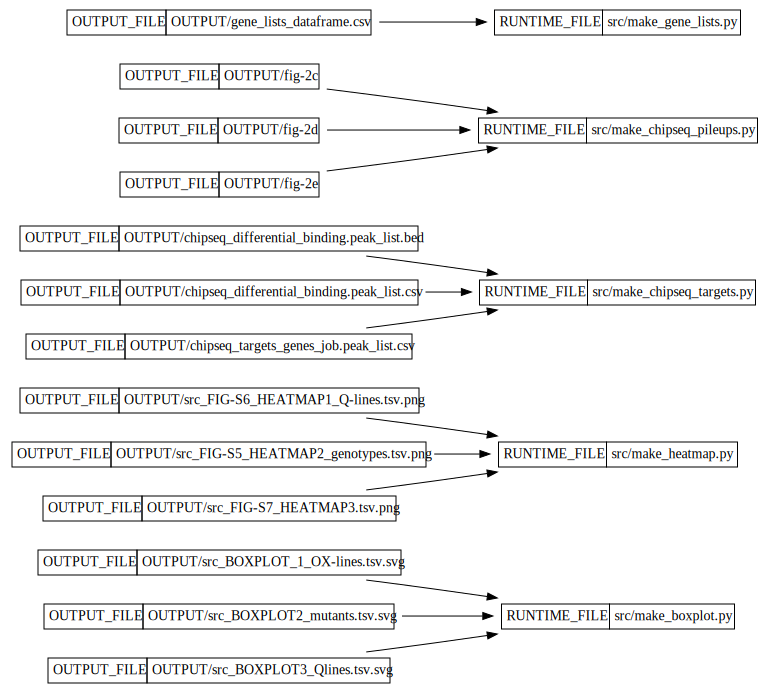

In [66]:
# pyext.readData()
# %pdb 0

# print s.source
pyext.ipd.SVG(FILE)    
# with open(FNAME,'r') as f:
    

In [ ]:
[(u'TS', 1574895735.892583),
 (u'OUTPUT_FILE', u'OUTPUT/src_BOXPLOT_1_OX-lines.tsv.svg'),
 (u'RUNTIME_FILE', u'src/make_boxplot.py')]

In [14]:
d

[(u'TS', 1574895735.892583),
 (u'OUTPUT_FILE', u'OUTPUT/src_BOXPLOT_1_OX-lines.tsv.svg'),
 (u'RUNTIME_FILE', u'src/make_boxplot.py')]

In [194]:
{"f1":"int", "f2":"value"}.values()

['int', 'value']

In [ ]:
!bash -e make_output.sh

In [151]:
import json
json.dump(ind)

In [149]:
!grep -rnw _get_output_file src/*.py   

src/make_boxplot.py:4:from src.util import _get_output_file
src/make_boxplot.py:35:    OFNAME = _get_output_file(OFNAME)
src/make_chipseq_pileups.py:5:from util import _get_file,_get_output_file
src/util.py:26:def _get_output_file(FNAME):


In [147]:
import pymisca.ext as pyext
# pyext.get_
from pymisca.header import get__frameName
# print get__frameName()
from pymisca.header import get__frameDict
get__frameDict??

In [ ]:
# ! python2 

In [ ]:
# %%python2
import pymisca.ext as pyext
fileList = []
d = {
    "OFNAME":'OUTPUT/gene_lists_dataframe.csv',
    'PURPOSE':"list of rna_signature_genes and chpiseq_target_genes"
}
fileList+=[d]

out = pyext._DICT_CLASS()
for key in [
    'signature_targets',
    'chipseq_targets_genes_job',
]:
    FMT = './WORKDIR/{key}/OUT.it'
    FNAME = pyext.f(FMT,)
    v = [x.strip() for x in list(pyext.readData(FNAME))]
    out[key]=v
    
L = max(map(len,out.values()))

for k in out:
    out[k] += [None] * (L - len(out[k]))
    pass

out = pyext.pd.DataFrame(out)
out.to_csv(fileList[-1]["OFNAME"],index=0)


##### list of peaks selected by comparing 17C and 27C ELF3 chip. 
fileList.append({'OFNAME':'./OUTPUT/chipseq_differential_binding.peak_list.csv',
 'PURPOSE':'list of peaks selected by comparing 17C and 27C ELF3 chip.'
})
pyext.file__link("WORKDIR/chipseq_targets_genes_job/PEAK_FILE.bed",fileList[-1]["OFNAME"],force=1)

####  list of peaks within 500bp of an annotated start codon
fileList.append({ "OFNAME": './OUTPUT/chipseq_targets_genes_job.peak_list.csv',
   "PURPOSE":"list of peaks within 500bp of an annotated start codon",
})

IFNAME = './WORKDIR/chipseq_targets_genes_job/PEAK_FILE.bed'
df_peakFile = df = pyext.readData(IFNAME,header=None,columns=pyext.columns.bed)
df.columns = df.columns.map(pyext.sanitise__column)

IFNAME = './WORKDIR/chipseq_targets_genes_job/PEAK_DIST.csv'
df_peakDist= df = pyext.readData(IFNAME)
df.columns = df.columns.map(pyext.sanitise__column)

# df2 = df_peakDist[['ACC','FEAT_ACC','FEAT_STRAND','DISTANCE']]
index = df_peakDist['ACC'].values.tolist()
res = pyext.pd.concat([
    df_peakFile.loc[:,:'STRAND'].set_index('ACC',drop=0).loc[index],
    df_peakDist.set_index('ACC')[['FEAT_ACC','FEAT_STRAND','DISTANCE']]
],axis=1,)
# df = df[['CHROM','START','END','ACC','SCORE','STRAND','FEAT_ACC','FEAT_STRAND','DISTANCE']]
df.to_csv(fileList[-1]["OFNAME"],index=0)

fileList.append({ "OFNAME": './OUTPUT',
   "PURPOSE":"Contain all plots",
})# pyext.ro
fileList.append({ "OFNAME": './src',
   "PURPOSE":"code",
})# pyext.ro
# pyext.list__toHtmlRow
df = pyext.pd.DataFrame(fileList)
df['FILE_ACC'] = df.pop('OFNAME')

print "DONE"

tb = pyext.validate__fileTable(df)
for d in tb:
    d.pop('FILE_ACC')
    d.pop('FULL_PATH')
tb = pyext.dicts__toHtmlTable(tb)
pyext.ipd.HTML(tb)




In [14]:
%pdb 1

Automatic pdb calling has been turned ON


import pdb
pdb.run('execfile("src/make_boxplot.py")')

In [7]:
??pyext.dir__real

In [8]:
! ls /home/feng/writable/teamkj/__backup/mapped-data/ChIP-seq/Mapped_data/192C/S17/ELF3myc-17C-ZT10_S17_Ath-TAIR10_RPKM.bw

/home/feng/writable/teamkj/__backup/mapped-data/ChIP-seq/Mapped_data/192C/S17/ELF3myc-17C-ZT10_S17_Ath-TAIR10_RPKM.bw


In [11]:
! ls src/static/

In [15]:
# %pdb 1
??LinkEvent

In [14]:
%pdb 0

Automatic pdb calling has been turned OFF


In [32]:
! ls src/static/
# ! rm src/static/Mapped_data/ -r

Mapped_data.189C.S10.gELF3myc-17C_S10_RPKM.bw
Mapped_data.189C.S11.gELF3myc-27C_S11_RPKM.bw
Mapped_data.189C.S16.1469-gELF3-myc-elf3-1xELF4-ox-ZT10-17C_S16_RPKM.bw
Mapped_data.189C.S17.1469-gELF3-myc-elf3-1xELF4-ox-ZT10-27C_S17_RPKM.bw
Mapped_data.192C.S1.1487-17-ZT10_S1_Ath-TAIR10_RPKM.bw
Mapped_data.192C.S17.ELF3myc-17C-ZT10_S17_Ath-TAIR10_RPKM.bw
Mapped_data.192C.S18.ELF3myc-27C-ZT10_S18_Ath-TAIR10_RPKM.bw
Mapped_data.192C.S2.1487-27-ZT10_S2_Ath-TAIR10_RPKM.bw
Mapped_data.192C.S3.1488-17-ZT10_S3_Ath-TAIR10_RPKM.bw
Mapped_data.192C.S4.1488-27-ZT10_S4_Ath-TAIR10_RPKM.bw


In [20]:
!python2 src/make_static_files.py

No module named graphviz


In [17]:
! ln -sf . src/src

ln: src/src/.: cannot overwrite directory


In [15]:
%run -d make_static_files.py

*** Blank or comment
*** Blank or comment
NOTE: Enter 'c' at the ipdb>  prompt to continue execution.
> /home/feng/envs/1126-polyq/make_static_files.py(2)<module>()
      1 
----> 2 from src.util import _file_static_copy,STATIC_DIR
      3 it = [
      4     ('/home/feng/writable/teamkj/__backup/mapped-data/ChIP-seq/',
      5      'Mapped_data/192C/S17/ELF3myc-17C-ZT10_S17_Ath-TAIR10_RPKM.bw',


KeyboardInterrupt
> /home/feng/envs/1126-polyq/make_static_files.py(4)<module>()
      2 from src.util import _file_static_copy,STATIC_DIR
      3 it = [
----> 4     ('/home/feng/writable/teamkj/__backup/mapped-data/ChIP-seq/',
      5      'Mapped_data/192C/S17/ELF3myc-17C-ZT10_S17_Ath-TAIR10_RPKM.bw',
      6      STATIC_DIR,

ipdb> q


In [22]:
! ls -lhtra src/static/

total 474M
drwxrwxr-x 4 feng feng  4.0K Nov 27 01:00 ..
-rw-rw-r-- 1 feng feng   27M Nov 27 01:00 Mapped_data.192C.S17.ELF3myc-17C-ZT10_S17_Ath-TAIR10_RPKM.bw
-rw-rw-r-- 1 feng feng   26M Nov 27 01:00 Mapped_data.192C.S18.ELF3myc-27C-ZT10_S18_Ath-TAIR10_RPKM.bw
-rw-rw-r-- 1 feng feng   39M Nov 27 01:00 Mapped_data.192C.S1.1487-17-ZT10_S1_Ath-TAIR10_RPKM.bw
-rw-rw-r-- 1 feng feng   39M Nov 27 01:00 Mapped_data.192C.S2.1487-27-ZT10_S2_Ath-TAIR10_RPKM.bw
-rw-rw-r-- 1 feng feng   40M Nov 27 01:00 Mapped_data.192C.S3.1488-17-ZT10_S3_Ath-TAIR10_RPKM.bw
-rw-rw-r-- 1 feng feng   38M Nov 27 01:00 Mapped_data.192C.S4.1488-27-ZT10_S4_Ath-TAIR10_RPKM.bw
-rw-rw-r-- 1 feng feng   21M Nov 27 01:00 Mapped_data.189C.S10.gELF3myc-17C_S10_RPKM.bw
-rw-rw-r-- 1 feng feng   37M Nov 27 01:00 Mapped_data.189C.S11.gELF3myc-27C_S11_RPKM.bw
-rw-rw-r-- 1 feng feng   31M Nov 27 01:00 Mapped_data.189C.S16.1469-gELF3-myc-elf3-1xELF4-ox-ZT10-17C_S16_RPKM.bw
-rw-rw-r-- 1 feng feng   33M Nov 27 01:00 Mapped_data.189C.S

In [43]:
for x in it:
    print "_get_file('%s'),"%x[1]
#     print repr((x[1],))
#     print x[1]

_get_file('Mapped_data/192C/S17/ELF3myc-17C-ZT10_S17_Ath-TAIR10_RPKM.bw'),
_get_file('Mapped_data/192C/S18/ELF3myc-27C-ZT10_S18_Ath-TAIR10_RPKM.bw'),
_get_file('Mapped_data/192C/S1/1487-17-ZT10_S1_Ath-TAIR10_RPKM.bw'),
_get_file('Mapped_data/192C/S2/1487-27-ZT10_S2_Ath-TAIR10_RPKM.bw'),
_get_file('Mapped_data/192C/S3/1488-17-ZT10_S3_Ath-TAIR10_RPKM.bw'),
_get_file('Mapped_data/192C/S4/1488-27-ZT10_S4_Ath-TAIR10_RPKM.bw'),
_get_file('Mapped_data/189C/S10/gELF3myc-17C_S10_RPKM.bw'),
_get_file('Mapped_data/189C/S11/gELF3myc-27C_S11_RPKM.bw'),
_get_file('Mapped_data/189C/S16/1469-gELF3-myc-elf3-1xELF4-ox-ZT10-17C_S16_RPKM.bw'),
_get_file('Mapped_data/189C/S17/1469-gELF3-myc-elf3-1xELF4-ox-ZT10-27C_S17_RPKM.bw'),


In [ ]:
%run --help

In [5]:
! ls -lhtr src/static/

total 473M
-rw-rw-r-- 1 feng feng  27M Nov 26 23:54 Mapped_data.192C.S17.ELF3myc-17C-ZT10_S17_Ath-TAIR10_RPKM.bw
-rw-rw-r-- 1 feng feng  26M Nov 26 23:54 Mapped_data.192C.S18.ELF3myc-27C-ZT10_S18_Ath-TAIR10_RPKM.bw
-rw-rw-r-- 1 feng feng  39M Nov 26 23:54 Mapped_data.192C.S1.1487-17-ZT10_S1_Ath-TAIR10_RPKM.bw
-rw-rw-r-- 1 feng feng  39M Nov 26 23:54 Mapped_data.192C.S2.1487-27-ZT10_S2_Ath-TAIR10_RPKM.bw
-rw-rw-r-- 1 feng feng  40M Nov 26 23:54 Mapped_data.192C.S3.1488-17-ZT10_S3_Ath-TAIR10_RPKM.bw
-rw-rw-r-- 1 feng feng  38M Nov 26 23:54 Mapped_data.192C.S4.1488-27-ZT10_S4_Ath-TAIR10_RPKM.bw
-rw-rw-r-- 1 feng feng  21M Nov 26 23:54 Mapped_data.189C.S10.gELF3myc-17C_S10_RPKM.bw
-rw-rw-r-- 1 feng feng  37M Nov 26 23:54 Mapped_data.189C.S11.gELF3myc-27C_S11_RPKM.bw
-rw-rw-r-- 1 feng feng  31M Nov 26 23:54 Mapped_data.189C.S16.1469-gELF3-myc-elf3-1xELF4-ox-ZT10-17C_S16_RPKM.bw
-rw-rw-r-- 1 feng feng  33M Nov 26 23:54 Mapped_data.189C.S17.1469-gELF3-myc-elf3-1xELF4-ox-ZT10-27C_S17_RPKM.bw
-

In [5]:
!tree OUTPUT

OUTPUT
├── chipseq_differential_binding.peak_list.bed
├── chipseq_differential_binding.peak_list.csv
├── fig-2c
│   ├── bwAvg.pk
│   ├── bwTable.pk
│   ├── chipseq_differential_binding.peak_list_radius=500.tsv
│   ├── DATA.json
│   ├── DONE
│   ├── MAIN.png
│   └── MAIN.svg
├── fig-2d
│   ├── bwAvg.pk
│   ├── bwTable.pk
│   ├── chipseq_differential_binding.peak_list_radius=500.tsv
│   ├── DATA.json
│   ├── DONE
│   ├── MAIN.png
│   └── MAIN.svg
├── fig-2e
│   ├── bwAvg.pk
│   ├── bwTable.pk
│   ├── chipseq_differential_binding.peak_list_radius=500.tsv
│   ├── DATA.json
│   ├── DONE
│   ├── MAIN.png
│   └── MAIN.svg
├── src_BOXPLOT_1_OX-lines.tsv.svg
├── src_BOXPLOT2_mutants.tsv.svg
├── src_BOXPLOT3_Qlines.tsv.svg
├── src_FIG-S5_HEATMAP2_genotypes.tsv.png
├── src_FIG-S6_HEATMAP1_Q-lines.tsv.png
└── src_FIG-S7_HEATMAP3.tsv.png

3 directories, 29 files


In [5]:
# pyext.readData("OUTPUT.EXPECT/gene_lists_dataframe.csv")

In [ ]:
gene_lists_dataframe.csv
chipseq_targets_genes_job.peak_list.csv

In [16]:
! ls -lhtr 

total 1.5M
drwxrwxr-x 4 feng feng 4.0K Nov 27 00:23 src
-rw-rw-r-- 1 feng feng 700K Nov 27 00:27 temp.bed
-rw-rw-r-- 1 feng feng 693K Nov 27 00:27 temp_radius=300.tsv
drwxrwxr-x 5 feng feng 4.0K Nov 27 00:27 OUTPUT
-rw-rw-r-- 1 feng feng 3.3K Nov 27 00:27 _temp-signature_targets-.it
drwxrwxr-x 5 feng feng 4.0K Nov 27 00:29 OUTPUT.EXPECT
-rw-rw-r-- 1 feng feng  34K Nov 27 00:30 1126-tidyup.ipynb


In [32]:
# ! ls -d ~/refer*
! ls /home/feng/
# !ls /home/Reference_genomes/

ls: cannot access '/home/feng/refer*': No such file or directory


In [9]:
! du -csh /home/feng/ref/Arabidopsis_thaliana_TAIR10/Annotation/genes.gtf.cds*

0	/home/feng/ref/Arabidopsis_thaliana_TAIR10/2
816M	/home/feng/ref/Arabidopsis_thaliana_TAIR10/Annotation
280K	/home/feng/ref/Arabidopsis_thaliana_TAIR10/GenomeStudio
4.0K	/home/feng/ref/Arabidopsis_thaliana_TAIR10/LOG
20K	/home/feng/ref/Arabidopsis_thaliana_TAIR10/Log.out
2.8G	/home/feng/ref/Arabidopsis_thaliana_TAIR10/STAR_INDEX
544K	/home/feng/ref/Arabidopsis_thaliana_TAIR10/Sequence
0	/home/feng/ref/Arabidopsis_thaliana_TAIR10/TAIR10_GFF3_genes.CDS.bed.summit
0	/home/feng/ref/Arabidopsis_thaliana_TAIR10/annotation
4.0K	/home/feng/ref/Arabidopsis_thaliana_TAIR10/genome.fa.fai
117M	/home/feng/ref/Arabidopsis_thaliana_TAIR10/genome.fa.real
0	/home/feng/ref/Arabidopsis_thaliana_TAIR10/genome.gtf
4.0K	/home/feng/ref/Arabidopsis_thaliana_TAIR10/genome.sizes
406M	/home/feng/ref/Arabidopsis_thaliana_TAIR10/jb
0	/home/feng/ref/Arabidopsis_thaliana_TAIR10/sequence
4.1G	total


In [25]:
import shutil

In [24]:
# pyext.absolutet.
with pyext.TempDirScope(keep=0):
    !pwd
    pass
# from pymisca.tree import TempDirScope

/tmp/tmp3fspmJ


In [ ]:
sdio.ex

In [10]:
import synotil.util as sutil
# sutil.peak2gene??
# import pymisca.ext aspyex
import synotil.dio as sdio
import src.util
src.util.ON_SERVER = 1
# from src.util import 
_get_file = src.util._get_file

OUTPUT_FILE = sdio.job__nearAUG(peakFile = "OUTPUT/chipseq_differential_binding.peak_list.bed",
                  featFile = _get_file("/home/feng/ref/Arabidopsis_thaliana_TAIR10/Annotation/genes.gtf.cds"),
#                  featFile = _get_file("/home/ref_genew/Arabidopsis_thaliana_TAIR10/Annotation/Genes/genes.gtf"),
#                   featFile = _get_file("/home/ref_genew/Arabidopsis_thaliana_TAIR10/Annotation/Genes/genes.gtf"),
                  GSIZE = _get_file("/home/feng/ref/Arabidopsis_thaliana_TAIR10/genome.sizes"),
                  CUTOFF=500,
                 )
OUTPUT_FILE

'job_nearAUG__peak_chipseq-differential-binding.peak-list.bed__cutoff_500__feat_genes.gtf.cds.tsv'

In [11]:
pyext.readData('job_nearAUG__peak_chipseq-differential-binding.peak-list.bed__cutoff_500__feat_genes.gtf.cds.tsv')

,Unnamed: 0,chrom,start,end,acc,score,strand,FC,neglogPval,neglogQval,summit,feat_acc,distance
0,0,1,2047863,2047864,ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_691,281,.,4.72083,28.13854,24.68937,579,AT1G06680,77
1,1,1,7531008,7531009,ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_2298,904,.,10.04510,90.43732,86.52003,520,AT1G21500,55
2,2,1,9275311,9275312,ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_2670,895,.,8.36736,89.55655,85.64711,534,AT1G26790,2
3,3,1,20803351,20803352,ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_4019,593,.,7.61039,59.30947,55.61438,610,AT1G55670,6
4,4,1,22700230,22700231,ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_4318,1063,.,10.51891,106.38649,102.31831,467,AT1G61520,80
5,5,1,26293062,26293063,ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_5012,734,.,8.65769,73.46611,69.68349,682,AT1G69830,60
6,6,1,27298493,27298494,ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_5233,404,.,6.36146,40.48586,36.92746,759,AT1G72500,64
7,7,1,28313580,28313581,ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_5566,102,.,3.28963,10.27953,7.17743,396,AT1G75440,43
8,8,2,591540,591541,ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_6238,278,.,5.40484,27.86801,24.42176,512,AT2G02230,56
9,9,2,12676003,12676004,ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_7593,97,.,2.64610,9.74363,6.66380,778,AT2G29650,1


In [6]:
! ls -lhtr 

total 309M
-rw-rw-r-- 1 feng feng 700K Nov 27 00:27 temp.bed
-rw-rw-r-- 1 feng feng 693K Nov 27 00:27 temp_radius=300.tsv
drwxrwxr-x 5 feng feng 4.0K Nov 27 00:27 OUTPUT
-rw-rw-r-- 1 feng feng 3.3K Nov 27 00:27 _temp-signature_targets-.it
drwxrwxr-x 5 feng feng 4.0K Nov 27 00:29 OUTPUT.EXPECT
drwxrwxr-x 4 feng feng 4.0K Nov 27 00:49 src
-rw-rw-r-- 1 feng feng  24K Nov 27 00:50 chipseq_differential_binding.peak_list.bed.summit.2796
-rw-rw-r-- 1 feng feng 101M Nov 27 00:50 genes.gtf.summit.2796
-rw-rw-r-- 1 feng feng 3.9M Nov 27 00:50 infiles:chipseq_differential_binding.peak_list.bed:genes.gtf__cutoff:5594.tsv
-rw-rw-r-- 1 feng feng 1.4M Nov 27 00:50 job_nearAUG__peak_chipseq-differential-binding.peak-list.bed__cutoff_6000__feat_genes.gtf.tsv
-rw-rw-r-- 1 feng feng  24K Nov 27 00:51 chipseq_differential_binding.peak_list.bed.summit
-rw-rw-r-- 1 feng feng 101M Nov 27 00:51 genes.gtf.summit
-rw-rw-r-- 1 feng feng  24K Nov 27 00:51 chipseq_differential_binding.peak_list.bed.summit.46
-rw-r

In [8]:
import pymisca.ext as pyext
pyext.readData('job_nearAUG__peak_chipseq-differential-binding.peak-list.bed__cutoff_500__feat_genes.gtf.tsv')

,Unnamed: 0,chrom,start,end,acc,score,strand,FC,neglogPval,neglogQval,summit,feat_acc,distance
0,0,1,2047863,2047864,ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_691,281,.,4.72083,28.13854,24.68937,579,2047779,40
1,1,1,2047863,2047864,ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_691,281,.,4.72083,28.13854,24.68937,579,2047840,23
2,2,1,2047863,2047864,ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_691,281,.,4.72083,28.13854,24.68937,579,2047894,77
3,3,1,2047863,2047864,ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_691,281,.,4.72083,28.13854,24.68937,579,2047894,77
4,4,1,2641625,2641626,ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_900,357,.,5.52243,35.79306,32.27345,869,2641519,62
5,5,1,2641625,2641626,ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_900,357,.,5.52243,35.79306,32.27345,869,2641519,62
6,6,1,6579264,6579265,ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_2070,272,.,4.98642,27.23555,23.79653,531,6579133,87
7,7,1,7531008,7531009,ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_2298,904,.,10.04510,90.43732,86.52003,520,7530909,55
8,8,1,7531008,7531009,ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_2298,904,.,10.04510,90.43732,86.52003,520,7530980,18
9,9,1,7531008,7531009,ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_2298,904,.,10.04510,90.43732,86.52003,520,7530909,55


In [3]:
??sdio.job__nearAUG

In [7]:
# ! grep -rw chipseq_targets_genes_job.peak_list.csv ../0726-polyq/*ipynb
! grep -rw gene_lists_dataframe.csv ../0726-polyq/src/
# "

../0726-polyq/src/rnaseq_figure.py:        df.to_csv("gene_lists_dataframe.csv",index=0)


In [2]:
!tree OUTPUT

OUTPUT
├── chipseq_differential_binding.peak_list.bed
├── chipseq_differential_binding.peak_list.csv
├── chipseq_targets_genes_job.peak_list.csv
├── fig-2c
│   ├── bwAvg.pk
│   ├── bwTable.pk
│   ├── chipseq_differential_binding.peak_list_radius=500.tsv
│   ├── DATA.json
│   ├── DONE
│   ├── MAIN.png
│   └── MAIN.svg
├── fig-2d
│   ├── bwAvg.pk
│   ├── bwTable.pk
│   ├── chipseq_differential_binding.peak_list_radius=500.tsv
│   ├── DATA.json
│   ├── DONE
│   ├── MAIN.png
│   └── MAIN.svg
├── fig-2e
│   ├── bwAvg.pk
│   ├── bwTable.pk
│   ├── chipseq_differential_binding.peak_list_radius=500.tsv
│   ├── DATA.json
│   ├── DONE
│   ├── MAIN.png
│   └── MAIN.svg
├── src_BOXPLOT_1_OX-lines.tsv.svg
├── src_BOXPLOT2_mutants.tsv.svg
├── src_BOXPLOT3_Qlines.tsv.svg
├── src_FIG-S5_HEATMAP2_genotypes.tsv.png
├── src_FIG-S6_HEATMAP1_Q-lines.tsv.png
└── src_FIG-S7_HEATMAP3.tsv.png

3 directories, 30 files


In [9]:
!tree OUTPUT.EXPECT/

OUTPUT.EXPECT/
├── chipseq_differential_binding.peak_list.csv
├── chipseq_targets_genes_job.peak_list.csv
├── fig1.png
├── fig-2c
│   ├── 1112__ELF3__chipTarg_radius=500.tsv
│   ├── bwAvg.pk
│   ├── bwTable.pk
│   ├── DATA.json
│   ├── DONE
│   ├── MAIN.png
│   └── MAIN.svg
├── fig-2d
│   ├── 1112__ELF3__chipTarg_radius=500.tsv
│   ├── bwAvg.pk
│   ├── bwTable.pk
│   ├── DATA.json
│   ├── DONE
│   ├── MAIN.png
│   └── MAIN.svg
├── fig-2e
│   ├── 1112__ELF3__chipTarg_radius=500.tsv
│   ├── bwAvg.pk
│   ├── bwTable.pk
│   ├── DATA.json
│   ├── DONE
│   ├── MAIN.png
│   └── MAIN.svg
├── figS4E_0905_pileup_heatmap.png
├── figS4E_0905.png
├── gene_lists_dataframe.csv
├── src_BOXPLOT_1_OX-lines.tsv.svg
├── src_BOXPLOT2_mutants.tsv.svg
├── src_BOXPLOT3_Qlines.tsv.svg
├── src_FIG-S5_HEATMAP2_genotypes.tsv.png
├── src_FIG-S6_HEATMAP1_Q-lines.tsv.png
├── src_FIG-S7_HEATMAP3.tsv.png
├── src_HEATMAP1_Q-lines.tsv.png
└── src_HEATMAP2_genotypes.tsv.png

3 directories, 35 files


In [116]:
!python2 src/make_gene_lists.py

No module named graphviz
/home/feng/.local/lib/python2.7/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)
is in ipython: 0 
[WARN] Cannot find file:key.gene
is in ipython: 0 
(10, 22)


In [123]:
! mv src/make_0918_elf3target_bed.py src/make_chipseq_diffgenes.py

In [124]:
! mv src/make_chipseq_diffgenes.py src/make_chipseq_targets.py

In [126]:
# !tree OUTPUT

OUTPUT
├── chipseq_differential_binding.peak_list.bed
├── chipseq_differential_binding.peak_list.bed.summit
├── chipseq_differential_binding.peak_list.csv
├── chipseq_targets_genes_job.peak_list.csv
├── fig-2c
│   ├── bwAvg.pk
│   ├── bwTable.pk
│   ├── chipseq_differential_binding.peak_list.bed_radius=500.tsv
│   ├── DATA.json
│   ├── DONE
│   ├── MAIN.png
│   └── MAIN.svg
├── fig-2d
│   ├── bwAvg.pk
│   ├── bwTable.pk
│   ├── chipseq_differential_binding.peak_list.bed_radius=500.tsv
│   ├── DATA.json
│   ├── DONE
│   ├── MAIN.png
│   └── MAIN.svg
├── fig-2e
│   ├── bwAvg.pk
│   ├── bwTable.pk
│   ├── chipseq_differential_binding.peak_list.bed_radius=500.tsv
│   ├── DATA.json
│   ├── DONE
│   ├── MAIN.png
│   └── MAIN.svg
├── gene_lists_dataframe.csv
├── src_BOXPLOT_1_OX-lines.tsv.svg
├── src_BOXPLOT2_mutants.tsv.svg
├── src_BOXPLOT3_Qlines.tsv.svg
├── src_FIG-S5_HEATMAP2_genotypes.tsv.png
├── src_FIG-S6_HEATMAP1_Q-lines.tsv.png
└── src_FIG-S7_HEATMAP3.tsv.png

3 directories, 32 files

In [132]:
%%bash
python2 src/make_static_files.py

No module named graphviz


In [134]:
%%bash
python2 src/make_boxplot.py

[WARN] Cannot find file:key.gene
(10, 22)
(10, 22)
(10, 22)


No module named graphviz
/home/feng/.local/lib/python2.7/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)
is in ipython: 0 
is in ipython: 0 


In [137]:
!tree -lh OUTPUT.EXPECT/ > OUTPUT.EXPECT.md

In [143]:
!git init . && git remote add origin https://github.com/shouldsee/polyq-figures

Initialised empty Git repository in /home/feng/envs/1126-polyq/.git/


In [ ]:
!git add

In [142]:
# !ls -lhtr 
!git add src OUTPUT/ OUTPUT.EXPECT.md make_output.sh 1126-tidyup.ipynb

fatal: Not a git repository (or any parent up to mount point /home)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [140]:
%%writefile .travis.yml
language: python
python:
  - "2.7"
  - "3.5"
cache: pip
install:
  - pip install -r requirements.txt
script:
  - bash make_output.sh


Writing .travis.yml


In [139]:
%%writefile make_output.sh
rm -rf OUTPUT
python2 src/make_boxplot.py
python2 src/make_heatmap.py
python2 src/make_chipseq_targets.py
python2 src/make_chipseq_pileups.py
python2 src/make_gene_lists.py
rm -f chip* home* genes* infiles* job* temp* _temp*


Writing make_output.sh


In [ ]:
import pymisca.ext as pyext

In [125]:
%%bash
rm -rf OUTPUT
python2 src/make_boxplot.py
python2 src/make_heatmap.py
python2 src/make_chipseq_targets.py
python2 src/make_chipseq_pileups.py
python2 src/make_gene_lists.py
rm -f chip* home* genes* infiles* job* temp* _temp*


[WARN] Cannot find file:key.gene
(10, 22)
(10, 22)
(10, 22)
[WARN] Cannot find file:key.gene
src/FIG-S6_HEATMAP1_Q-lines.tsv
(10, 22)
src/FIG-S5_HEATMAP2_genotypes.tsv
(10, 22)
src/FIG-S7_HEATMAP3.tsv
(10, 22)
6982
[L] 6982
[L]= 60
[L]= 60
[L]= 60
[L]= 60
[L] 244
[L]= 100
[L]= 100
[WARN] Cannot find file:key.gene

 [WARN] unable to simplify condName. Exception:list index out of range
[L] 244
[L]= 100
[L]= 100
[L]= 100
[L]= 100

 [WARN] unable to simplify condName. Exception:list index out of range
[L] 244
[L]= 100
[L]= 100
[L]= 100
[L]= 100

 [WARN] unable to simplify condName. Exception:list index out of range
[WARN] Cannot find file:key.gene
(10, 22)


No module named graphviz
/home/feng/.local/lib/python2.7/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)
is in ipython: 0 
is in ipython: 0 
No module named graphviz
/home/feng/.local/lib/python2.7/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)
is in ipython: 0 
is in ipython: 0 
No module named graphviz
is in ipython: 0 
is in ipython: 0 
No module named graphviz
No module named graphviz
/home/feng/.local/lib/python2.7/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum support

In [129]:
! du -csh */* | sort -h

0	src/__init__.py
0	src/src
4.0K	src/0918-elf3target.bed.pyc
4.0K	src/BOXPLOT_1_OX-lines.csv
4.0K	src/BOXPLOT_1_OX-lines.tsv
4.0K	src/BOXPLOT2_mutants.tsv
4.0K	src/BOXPLOT3_Qlines.tsv
4.0K	src/FIG-S5_HEATMAP2_genotypes.tsv
4.0K	src/FIG-S6_HEATMAP1_Q-lines.tsv
4.0K	src/FIG-S7_HEATMAP3.tsv
4.0K	src/get_depth.py
4.0K	src/__init__.pyc
4.0K	src/key_ath.csv
4.0K	src/make_boxplot.py
4.0K	src/make_chipseq_targets.py
4.0K	src/make_final_soft.py
4.0K	src/make_gene_lists.py
4.0K	src/make_heatmap.py
4.0K	src/make_meta_soft.py
4.0K	src/make_static_files.py
4.0K	src/obj_chipeq_db.pyc
4.0K	src/obj_chipseq_db.py
4.0K	src/obj_chipseq_db.pyc
4.0K	src/plot_bigwig_pileup.py
4.0K	src/plot_bigwig_pileup.pyc
4.0K	src/polyq-0830.get_soft_text_jaehoon.tar.gz
4.0K	src/util.py
4.0K	src/util.pyc
4.0K	src/validate_fastq.py
4.0K	src/validate_fastq.pyc
8.0K	OUTPUT.EXPECT/gene_lists_dataframe.csv
8.0K	OUTPUT/gene_lists_dataframe.csv
8.0K	src/chipseq_figure.py
8.0K	src/chipseq_figure.pyc
8.0K	src/make_chipseq_pileups.

In [122]:
# ! find 
# !ls -1 .
!rm -f chip* home* genes* infiles* job* temp* _temp*


1126-tidyup.ipynb
OUTPUT
OUTPUT.EXPECT
src


In [115]:
%%writefile src/make_gene_lists.py
import pymisca.ext as pyext

import src.rnaseq_figure
df = pyext.OrderedDict()
df["signature_targets"] = (src.rnaseq_figure.job['signature_targets'])
df["chipseq_targets_genes"] = pyext.readData("OUTPUT/chipseq_targets_genes_job.peak_list.csv")['feat_acc'].unique()
# df = pyext.pd.DataFrame(map(pyext.pd.Series(df.items())))
df = pyext.pd.DataFrame.from_dict(df,orient='index').T
df.to_csv("OUTPUT/gene_lists_dataframe.csv",index=0)


Writing src/make_gene_lists.py


In [101]:
pyext.readData("OUTPUT.EXPECT/gene_lists_dataframe.csv")

,chipseq_targets_genes_job
signature_targets,
AT1G02340,AT1G03130
AT1G03106,AT1G06040
AT1G03120,AT1G06680
AT1G03130,AT1G07030
AT1G04180,AT1G08380
AT1G04560,AT1G09210
AT1G04660,AT1G15820
AT1G05835,AT1G19050
AT1G06040,AT1G21500


In [1]:
%pdb 1
%run src/make_0918_elf3target_bed.py


Automatic pdb calling has been turned ON


No module named graphviz
is in ipython: 1 


6982


/home/feng/.local/lib/python2.7/site-packages/pandas/core/computation/check.py:17: UserWarning:

The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6




[L] 6982
[L]= 60
[L]= 60
[L]= 60
[L]= 60


/home/feng/.local/lib/python2.7/site-packages/pandas/core/groupby/groupby.py:4327: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



In [5]:
# with pyext.TempDirScope(keep=0) as d:
#     pass
# d._root

FrozenPath(u'/home/feng/envs/1126-polyq')

In [23]:
(752847 + 754658 )/2

753752

In [22]:
2847 + 1488 

4335

In [14]:
!head -n100 OUTPUT/chipseq_differential_binding.peak_list.bed

1	147683	148213	ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_39	30	.	1.87894	3.09096	0.77512	138
1	219777	220512	ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_58	148	.	4.13066	14.899779999999998	11.64974	402
1	570870	571644	ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_186	643	.	8.03422	64.37534000000001	60.64763000000001	536
1	752847	754658	ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_259	1349	.	15.29859	134.95708	130.6795	1488
1	1235886	1236636	ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_426	68	.	2.70837	6.8584	3.92995	175
1	1745486	1746170	ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_568	284	.	5.37466	28.48123	25.0288	375
1	1828468	1830462	ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_611	1269	.	12.10369	126.97205	122.75084	1448
1	2047142	2048585	ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_691	281	.	4.72083	28.138540000000006	24.68937	579
1	2640980	2642271	ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_900	357	.	5.52243	35.79306	32.27345	869
1	3019348	3019955	ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_1034	132	.	3.722480000000001	13.24302	10.03542	196
1	3072555	

In [38]:
len(res[0])

60

In [41]:
res[0].to_csv()

,chrom,start,end,acc,score,strand,FC,neglogPval,neglogQval,summit,feat_chrom,feat_start,feat_end,feat_acc,feat_score,feat_strand,feat_FC,distance
0,1,147184,148712,ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_39,30,.,1.87894,3.09096,0.77512,138,1,146767,147766,AT1G01380,.,+,CDS,418
1,1,219278,221011,ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_58,148,.,4.13066,14.89978,11.64974,402,1,218700,219699,AT1G01600,.,+,CDS,579
2,1,752348,755157,ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_259,1349,.,15.29859,134.95708,130.67950,1488,1,751771,752770,AT1G03120,.,+,CDS,578
5,1,1235387,1237135,ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_426,68,.,2.70837,6.85840,3.92995,175,1,1236756,1237755,AT1G04540,.,+,CDS,621
6,1,1744987,1746669,ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_568,284,.,5.37466,28.48123,25.02880,375,1,1744343,1745342,AT1G05805,.,+,CDS,645
12,1,3072056,3073738,ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_1055,119,.,3.10581,11.94217,8.77707,546,1,3071531,3072530,AT1G09520,.,-,CDS,526
13,1,3239738,3241711,ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_1112,162,.,3.87067,16.27102,12.98732,438,1,3238763,3239762,AT1G09940,.,-,CDS,976
14,1,3239738,3241711,ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_1112,162,.,3.87067,16.27102,12.98732,438,1,3241042,3242041,AT1G09950,.,-,CDS,331
15,1,3444118,3445489,ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_1173,158,.,3.54062,15.83519,12.55976,187,1,3443260,3444259,AT1G10470,.,-,CDS,859
16,1,4228924,4231817,ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_1393,400,.,5.97953,40.07447,36.51927,619,1,4228418,4229417,AT1G12420,.,-,CDS,507


In [55]:
OUTPUT_BED_FILE

'OUTPUT/chipseq_differential_binding.peak_list.bed.summit'

In [73]:
# ??synotil.dio.bed__summit
??synotil.dio.extract_bigwig_multiple

In [75]:
??synotil.dio.npk_expandSummit

In [90]:
!wc -l OUTPUT/chipseq_targets_genes_job.peak_list.csv

123 OUTPUT/chipseq_targets_genes_job.peak_list.csv


In [91]:
!tree OUTPUT

OUTPUT
├── chipseq_differential_binding.peak_list.bed
├── chipseq_differential_binding.peak_list.bed.summit
├── chipseq_differential_binding.peak_list.csv
├── chipseq_targets_genes_job.peak_list.csv
├── fig-2c
│   ├── bwAvg.pk
│   ├── bwTable.pk
│   ├── chipseq_differential_binding.peak_list.bed_radius=500.tsv
│   ├── DATA.json
│   ├── DONE
│   ├── MAIN.png
│   └── MAIN.svg
├── fig-2d
│   ├── bwAvg.pk
│   ├── bwTable.pk
│   ├── chipseq_differential_binding.peak_list.bed_radius=500.tsv
│   ├── DATA.json
│   ├── DONE
│   ├── MAIN.png
│   └── MAIN.svg
└── fig-2e
    ├── bwAvg.pk
    ├── bwTable.pk
    ├── chipseq_differential_binding.peak_list.bed_radius=500.tsv
    ├── DATA.json
    ├── DONE
    ├── MAIN.png
    └── MAIN.svg

3 directories, 25 files


In [88]:
!python2 src/make_0918_elf3target_bed.py
# !python2 src/make_chipseq_pileups.py

No module named graphviz
is in ipython: 0 
is in ipython: 0 
6982
[L] 6982
[L]= 60
[L]= 60
[L]= 60
[L]= 60


In [80]:
!rm -r OUTPUT/

In [76]:
FNAME = 'OUTPUT/chipseq_differential_binding.peak_list.bed'
shutil.move(synotil.dio.npk_expandSummit(FNAME,radius=1,),FNAME+'.summit')

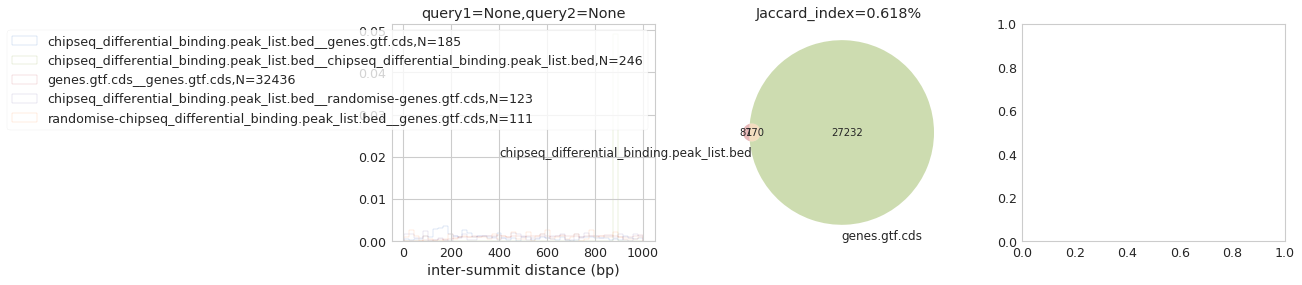

In [77]:
# %matplotlib inline
import synotil.qcplots
import synotil.dio

#### making gene list
OUTPUT_FILE = "OUTPUT/chipseq_targets_genes_job.peak_list.csv"
INPUT_BED_FILE = 'OUTPUT/chipseq_differential_binding.peak_list.bed.summit'

GSIZE = _get_file("/home/feng/ref/Arabidopsis_thaliana_TAIR10/genome.sizes")

# INPUT_BED_FILE = synotil.dio.bed__summit(INPUT_BED_FILE,GSIZE=GSIZE,)
# OUTPUT_BED_FILE = ""
# peak2 = synotil.dio.bed__leftSummit("/home/feng/ref/Arabidopsis_thaliana_TAIR10/Annotation/genes.gtf.cds",GSIZE=GSIZE)
res = synotil.qcplots.qc_summitDist(peak1= OUTPUT_BED_FILE,
                              CUTOFF=500,
                              peak2 = synotil.dio.bed__leftSummit("/home/feng/ref/Arabidopsis_thaliana_TAIR10/Annotation/genes.gtf.cds",GSIZE=GSIZE),
                              GSIZE =GSIZE,
                             );

res[0].to_csv(OUTPUT_FILE)

In [78]:
! python2 src/make_chipseq_pileups.py

No module named graphviz
[L] 244
[L]= 100
[L]= 100
[WARN] Cannot find file:key.gene

 [WARN] unable to simplify condName. Exception:list index out of range
[L] 244
[L]= 100
[L]= 100
[L]= 100
[L]= 100

 [WARN] unable to simplify condName. Exception:list index out of range
[L] 244
[L]= 100
[L]= 100
[L]= 100
[L]= 100

 [WARN] unable to simplify condName. Exception:list index out of range


[CMD]ls -1  OUTPUT/*/*.png


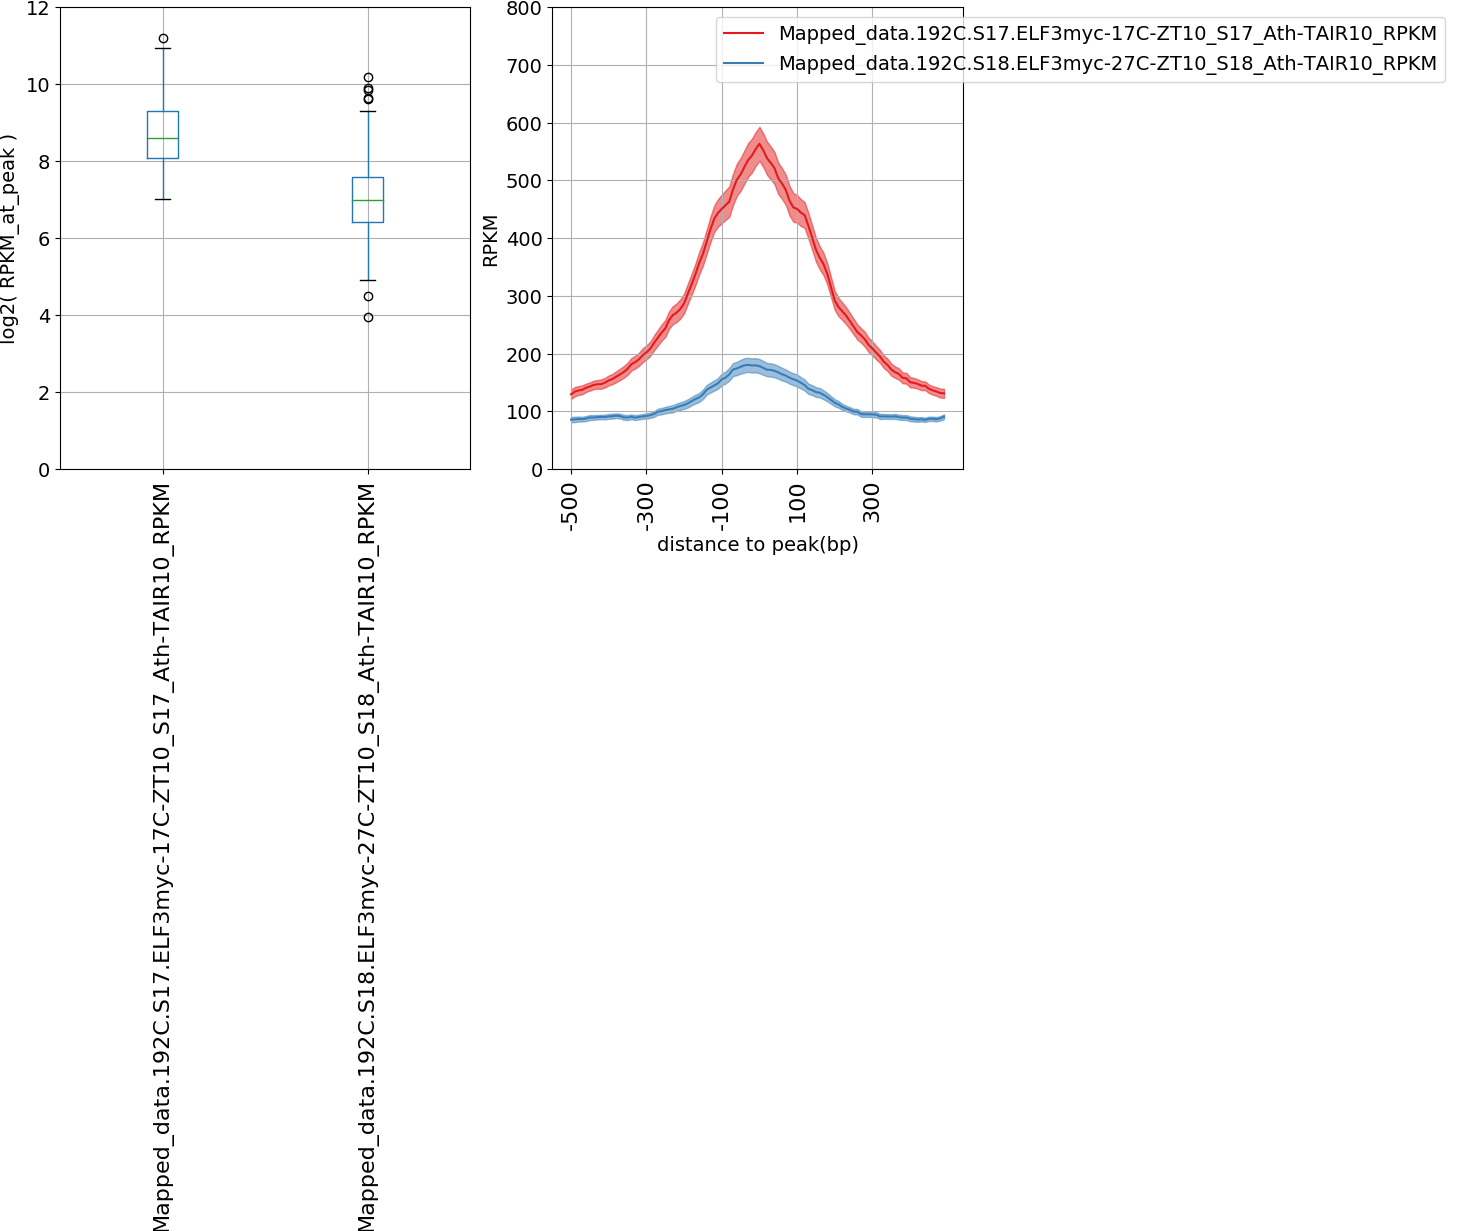

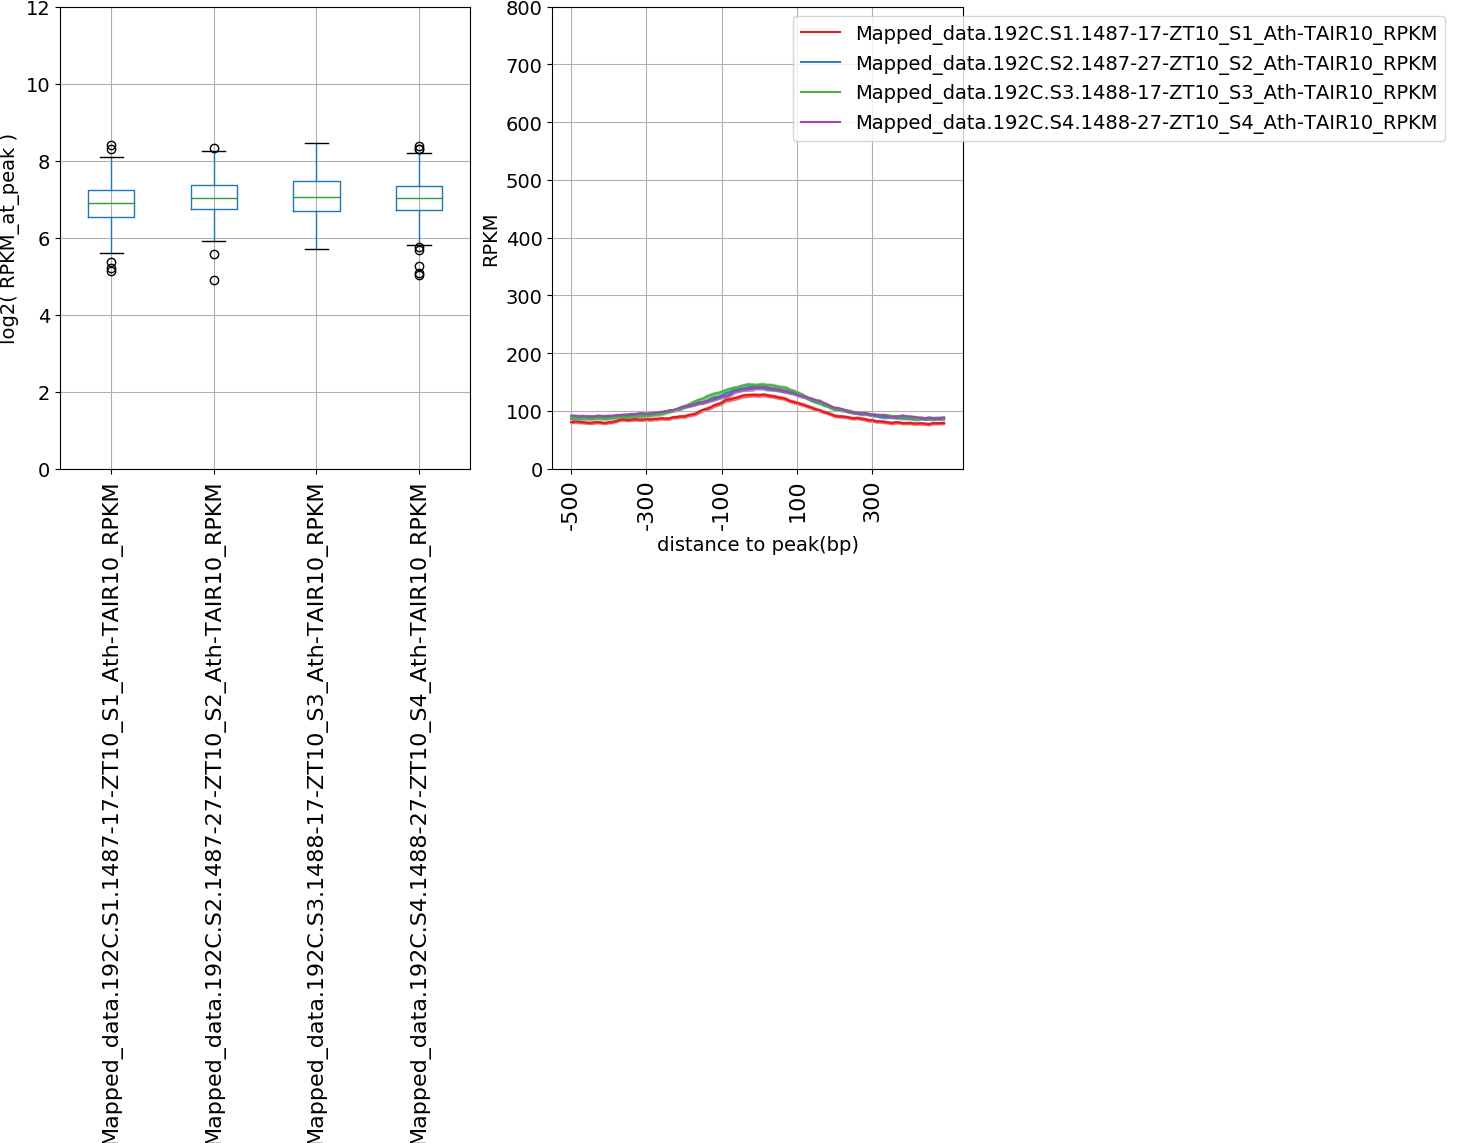

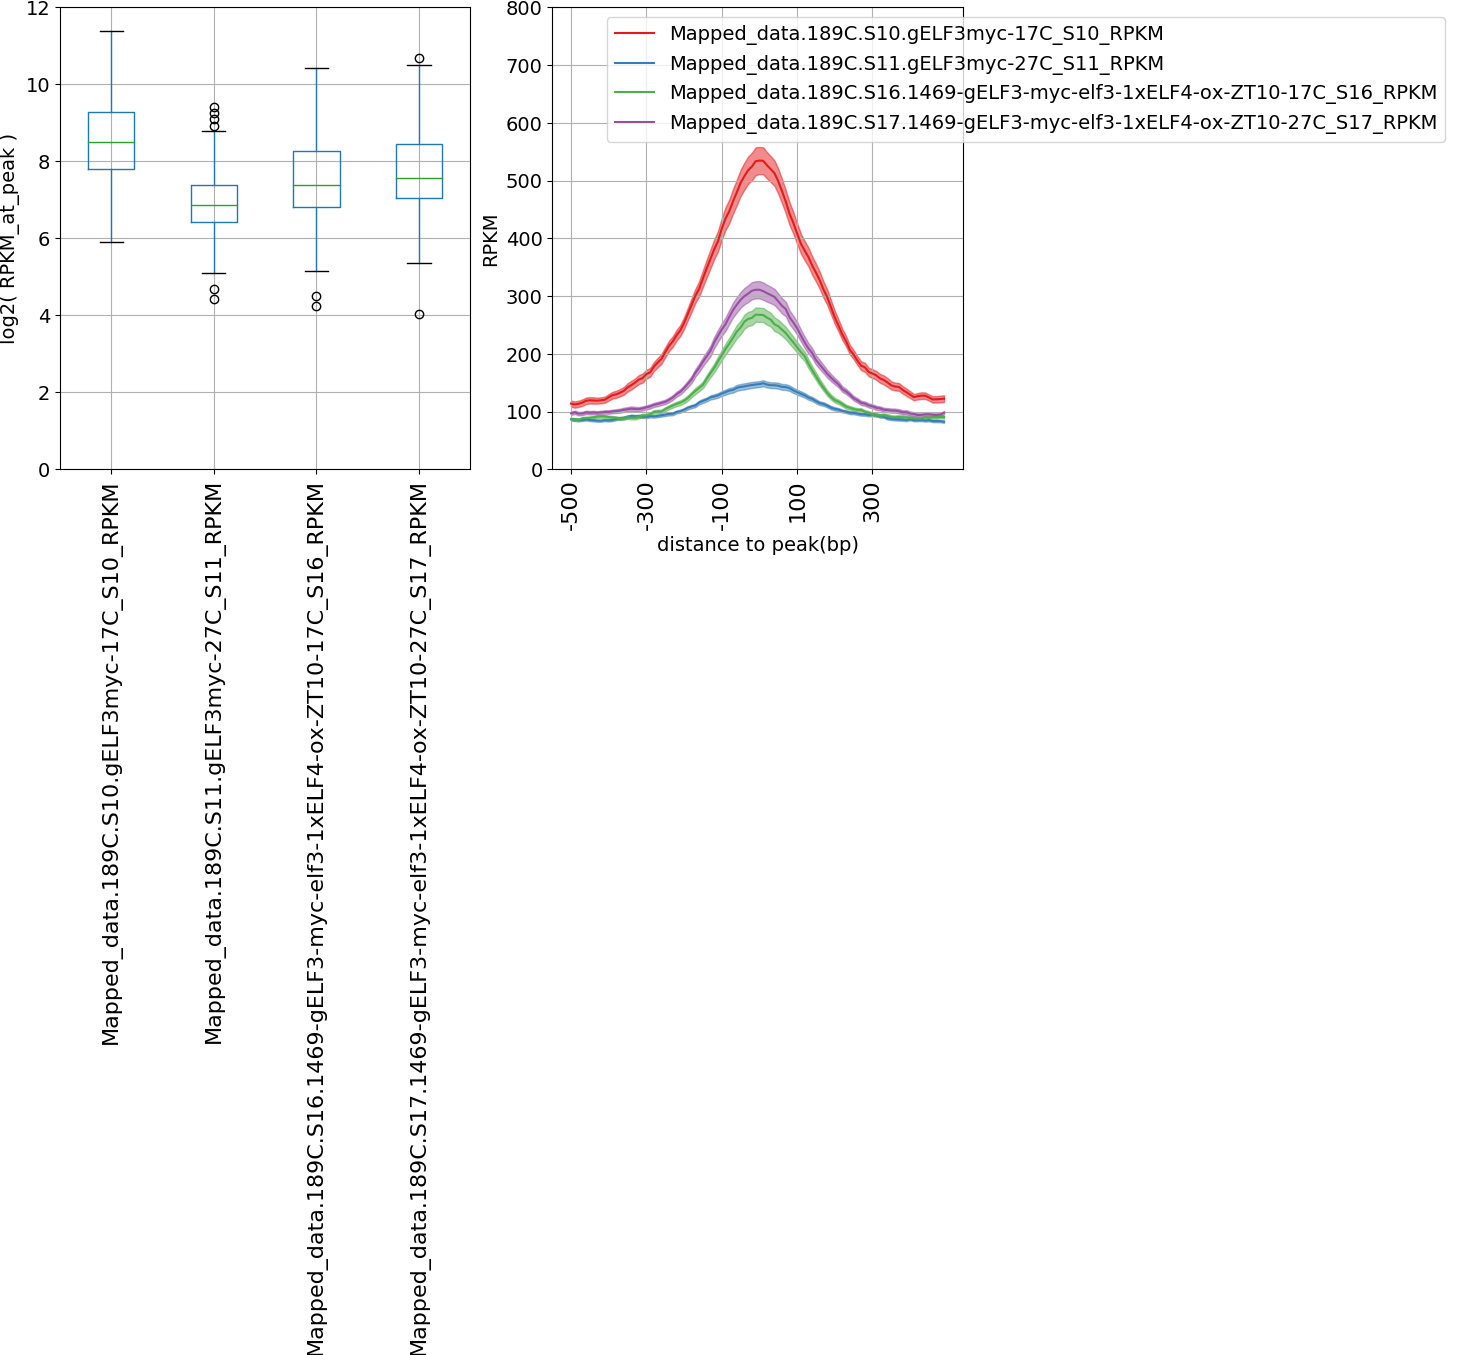

In [85]:
for img  in pyext.shellexec("ls -1  OUTPUT/*/*.png").splitlines():
#     pyext.ipd.display(pyext.ipd.SVG(img))
    pyext.ipd.display(pyext.ipd.Image(img))
    

[CMD]ls -1 OUTPUT/*.svg OUTPUT/*/*.png


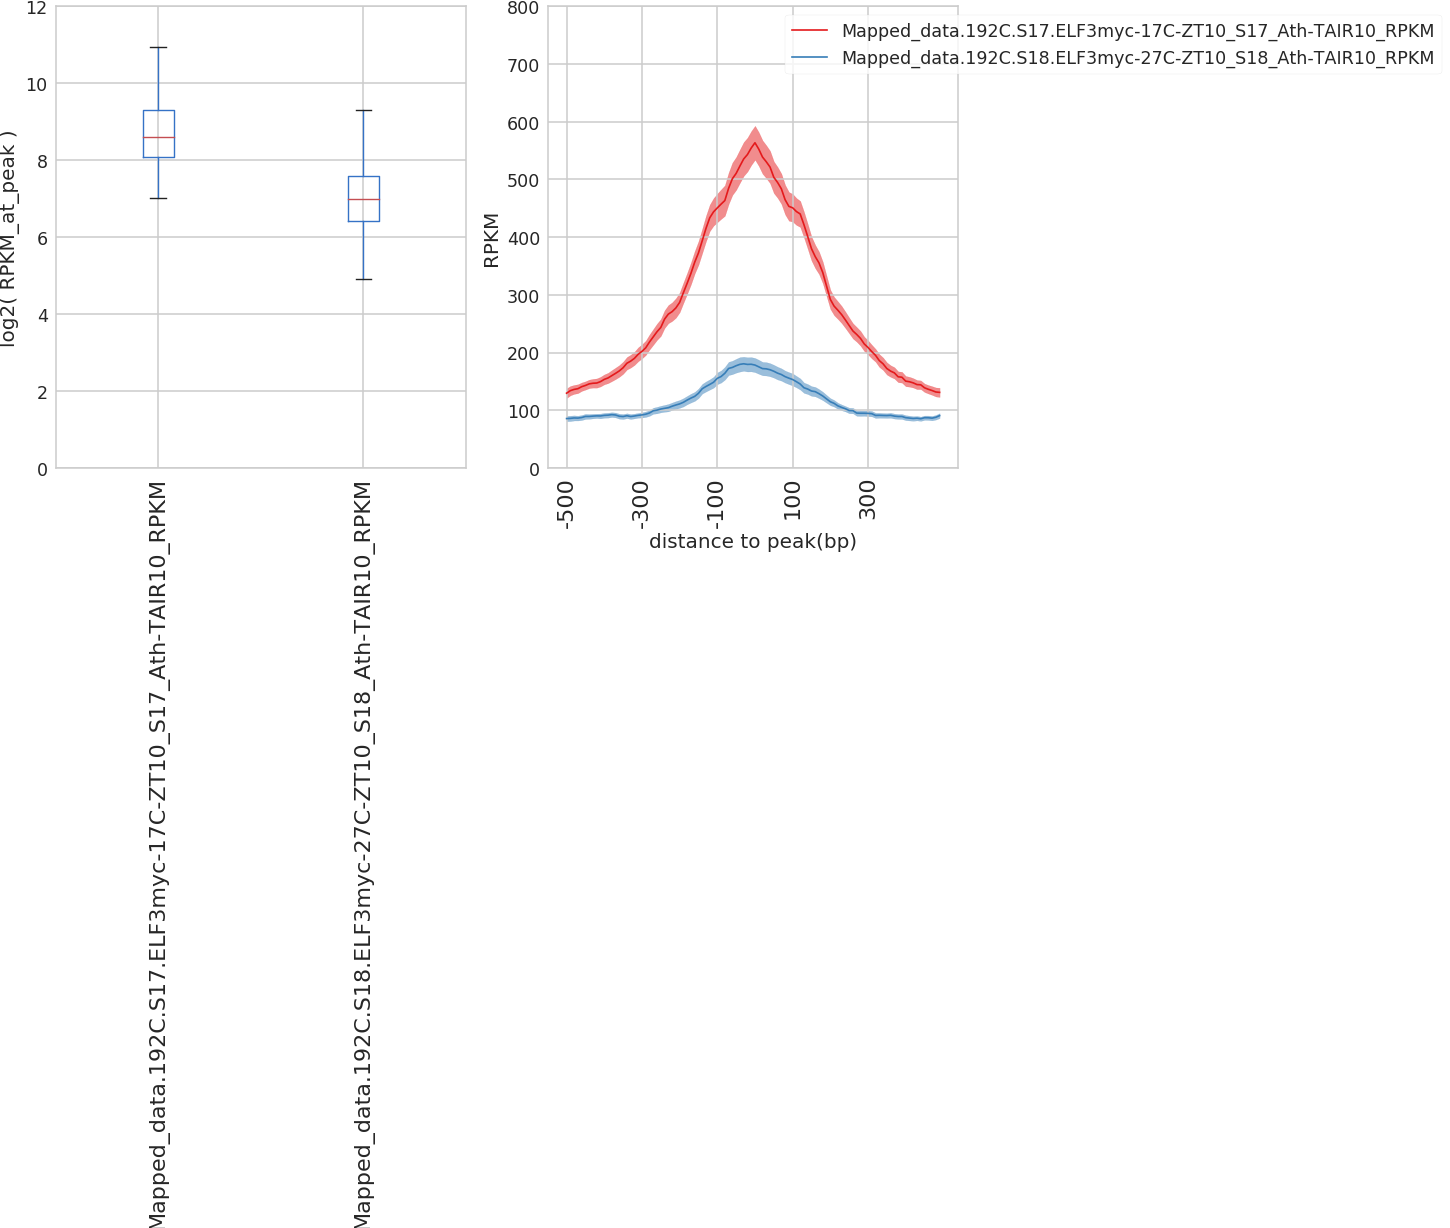

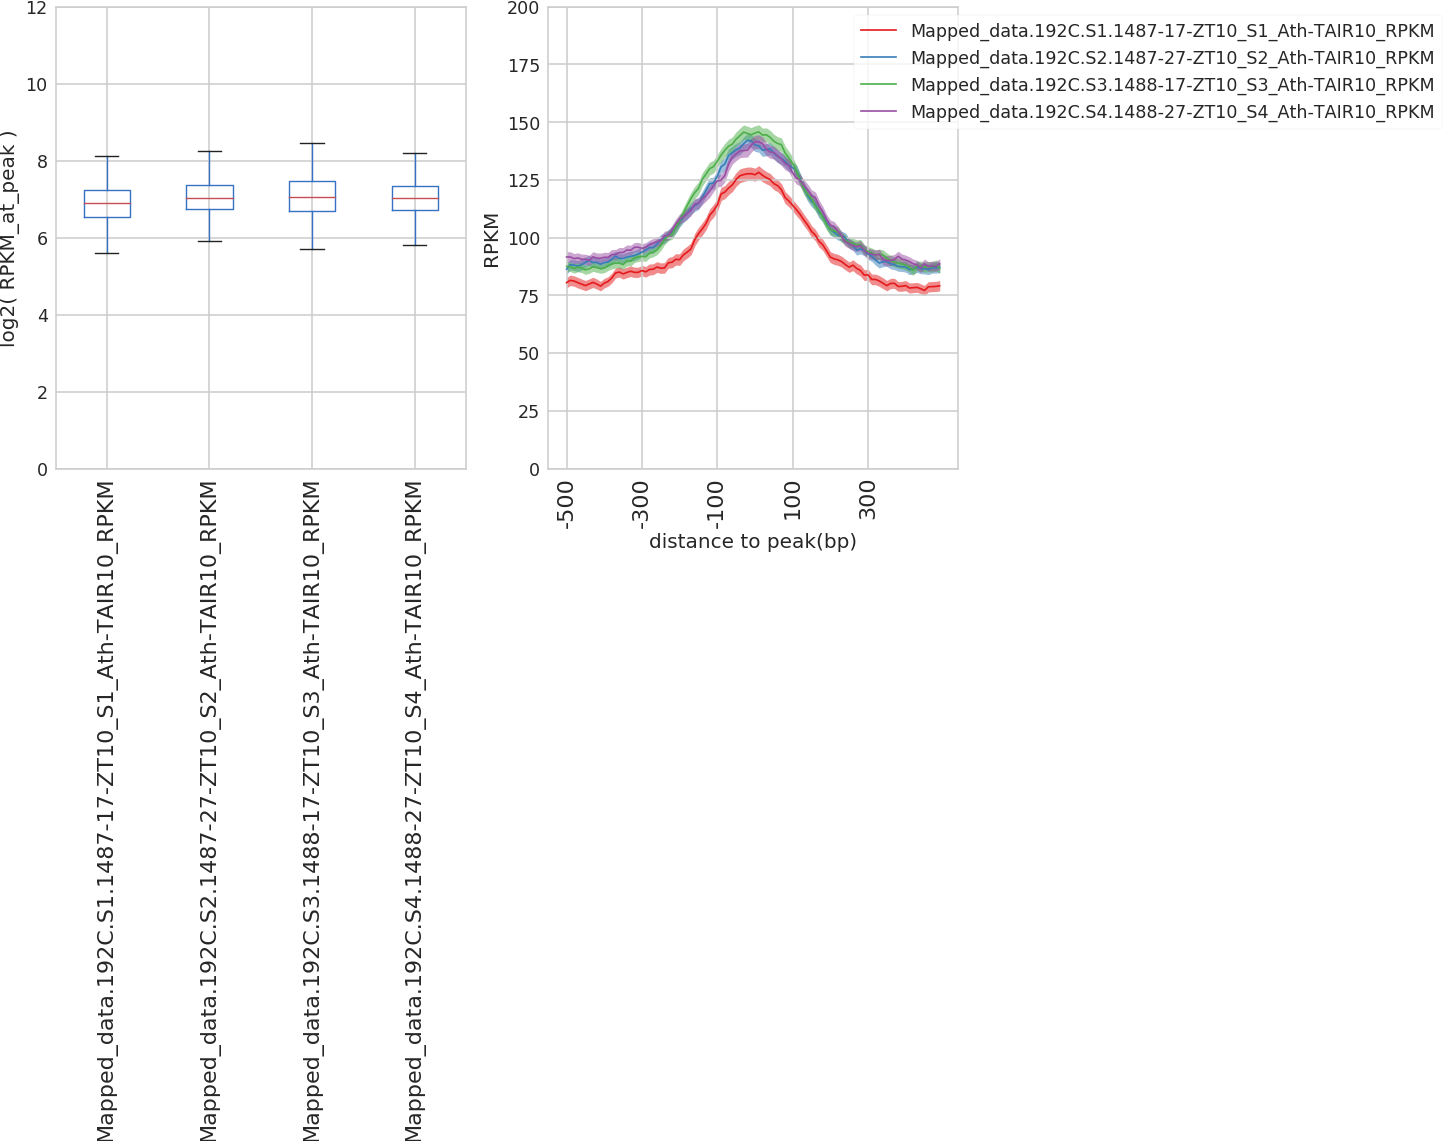

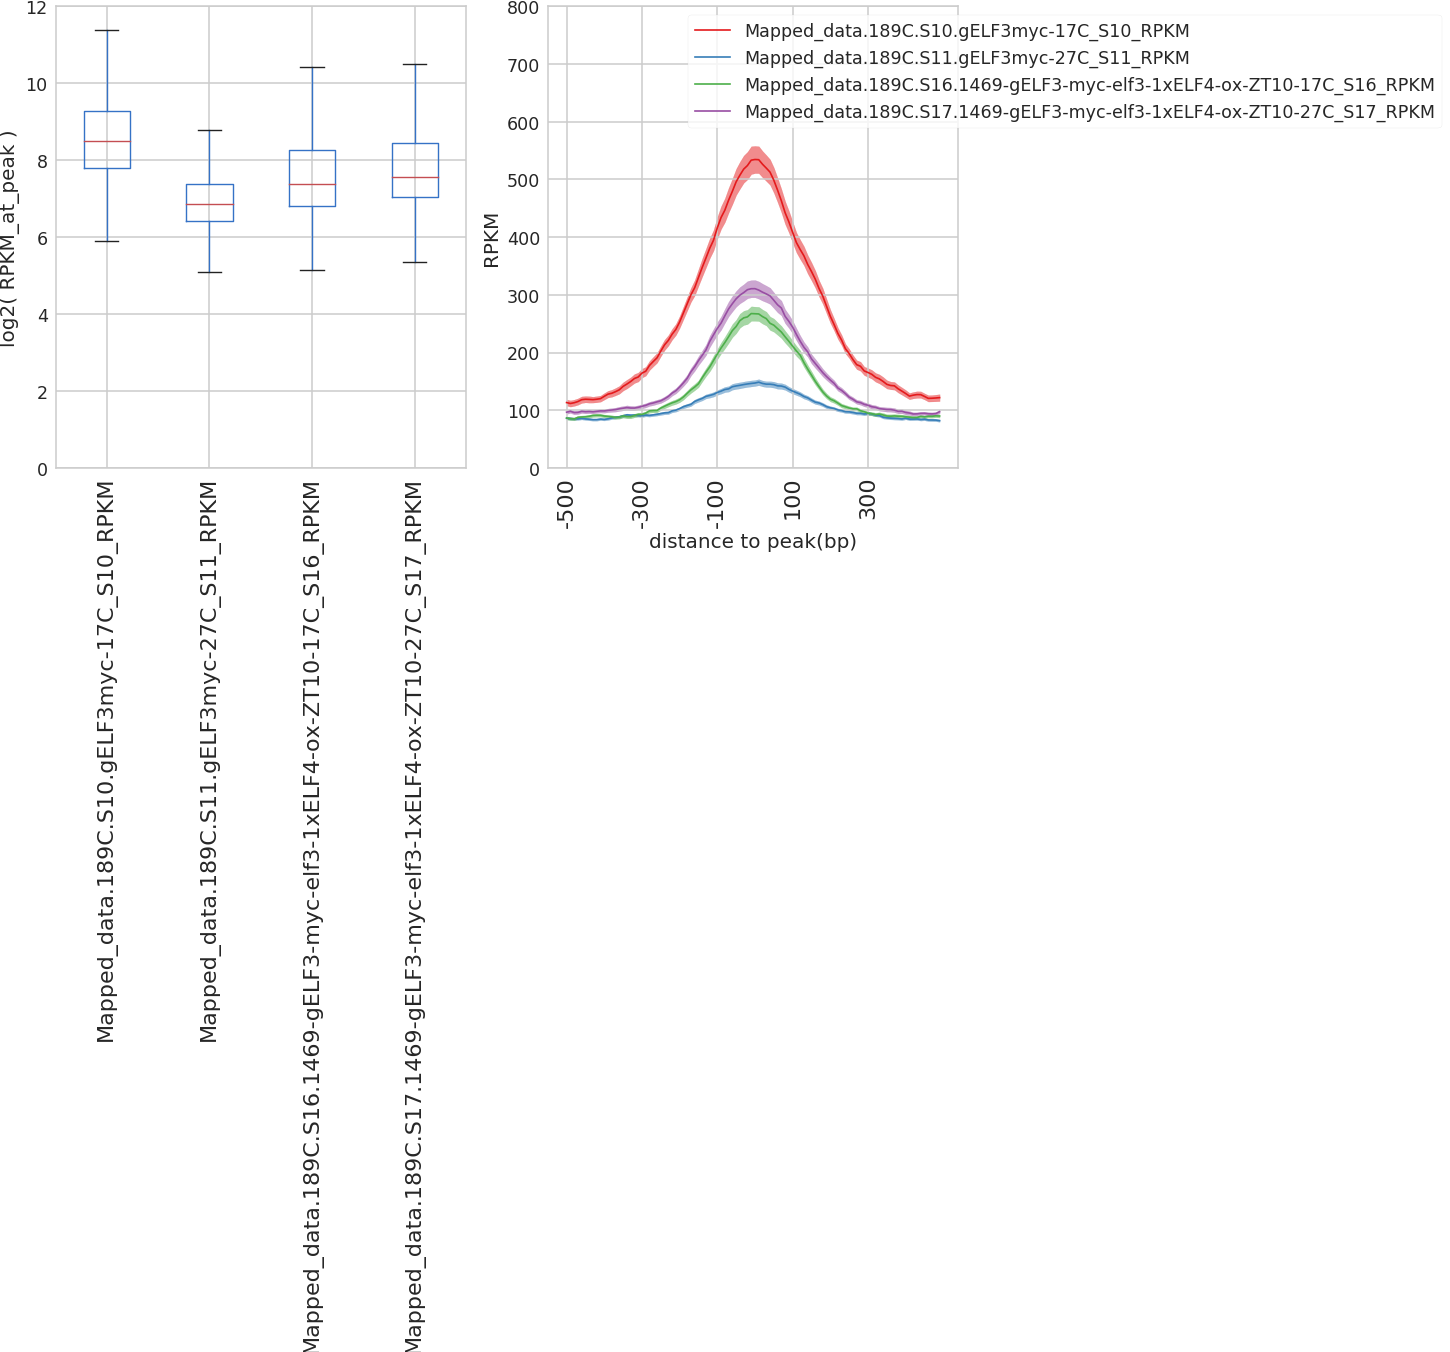

ValueError: Cannot embed the 'svg' image format

In [64]:
for img  in pyext.shellexec("ls -1 OUTPUT/*.svg OUTPUT/*/*.png").splitlines():
#     pyext.ipd.display(pyext.ipd.SVG(img))
    pyext.ipd.display(pyext.ipd.Image(img))
    

In [ ]:
# OUTPUT_BED_FILE = os.path.realpath(OUTPUT_BED_FILE)
import synotil.dio


with pyext.TempDirScope(keep=0) as d:
    _TEMP_OUTPUT=  synotil.dio.job__nearAUG(peakFile = d._root / OUTPUT_BED_FILE,
                  featFile = _get_file("/home/feng/ref/Arabidopsis_thaliana_TAIR10/Annotation/genes.gtf.cds"),
#                  featFile = _get_file("/home/ref_genew/Arabidopsis_thaliana_TAIR10/Annotation/Genes/genes.gtf"),
#                   featFile = _get_file("/home/ref_genew/Arabidopsis_thaliana_TAIR10/Annotation/Genes/genes.gtf"),
                  GSIZE = _get_file("/home/feng/ref/Arabidopsis_thaliana_TAIR10/genome.sizes"),
                  CUTOFF=500,
                 )
    ### csv to tsv
    pyext.readData(_TEMP_OUTPUT).to_csv(d._root / "OUTPUT/chipseq_targets_genes_job.peak_list.csv",)

In [24]:
# sdio
import synotil.dio
synotil.dio.bed__leftSummit()

In [17]:
# !head OUTPUT/chipseq_targets_genes_job.peak_list.csv
pyext.readData("OUTPUT/chipseq_targets_genes_job.peak_list.csv",ext='tsv').head()

,Unnamed: 0,chrom,start,end,acc,score,strand,FC,neglogPval,neglogQval,summit,feat_acc,distance
0,0,1,2047863,2047864,ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_691,281,.,4.72083,28.13854,24.68937,579,AT1G06680,77
1,1,1,7531008,7531009,ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_2298,904,.,10.04510,90.43732,86.52003,520,AT1G21500,55
2,2,1,9275311,9275312,ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_2670,895,.,8.36736,89.55655,85.64711,534,AT1G26790,2
3,3,1,20803351,20803352,ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_4019,593,.,7.61039,59.30947,55.61438,610,AT1G55670,6
4,4,1,22700230,22700231,ELF3myc-17C-ZT10_S17_Ath-TAIR10_peak_4318,1063,.,10.51891,106.38649,102.31831,467,AT1G61520,80


In [21]:
(3503 + 4002) // 2

3752

In [20]:
(3893 + 4392 ) //2

4142

In [47]:
pyext.readData("OUTPUT.EXPECT/chipseq_targets_genes_job.peak_list.csv")['DISTANCE'].max()
# distance
# .shape

492

In [8]:
%%bash
NAME=chipseq_targets_genes_job.peak_list.csv
# ./OUTPUT/
wc -l OUTPUT/$NAME OUTPUT.EXPECT/$NAME

   25 OUTPUT/chipseq_targets_genes_job.peak_list.csv
  163 OUTPUT.EXPECT/chipseq_targets_genes_job.peak_list.csv
  188 total


In [2]:
! ls -lhtr OUTPUT/chipseq_differential_binding.peak_list.bed

-rw-rw-r-- 1 feng feng 24K Nov 27 01:07 OUTPUT/chipseq_differential_binding.peak_list.bed


In [3]:
%pdb 1
# ! rm -rf OUTPUT
%run src/make_boxplot.py
%run src/make_0918_elf3target_bed.py
%run src/make_chipseq_pileups.py
%run src/make_heatmap.py
%run src/makmake_heatmap.py
"DONE"

Automatic pdb calling has been turned ON
(10, 22)
(10, 22)
(10, 22)
6982
[L] 6982
[L]= 60
[L]= 60
[L]= 60
[L]= 60
[L] 244
[L]= 100
[L]= 100

 [WARN] unable to simplify condName. Exception:list index out of range
[L] 244
[L]= 100
[L]= 100
[L]= 100
[L]= 100

 [WARN] unable to simplify condName. Exception:list index out of range
[L] 244
[L]= 100
[L]= 100
[L]= 100
[L]= 100

 [WARN] unable to simplify condName. Exception:list index out of range
src/FIG-S6_HEATMAP1_Q-lines.tsv
(10, 22)
src/FIG-S5_HEATMAP2_genotypes.tsv
(10, 22)
src/FIG-S7_HEATMAP3.tsv
(10, 22)


ERROR:root:File `u'src/makmake_heatmap.py'` not found.


'DONE'